In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import pickle
from scipy.stats import norm
import os
import sys
sys.path.append('..')

from familiarity.familiarization import get_results , dprime_roc_auc
from familiarity.config import DATA_DIR

In [2]:
dataset='lfw-deepfunneled'
net = 'vgg16_train-vggface2'
imset = 'lfw-deepfunneled-subset_thresh-18_val-10'
save_dir='../figures'
data_dir=os.path.join(DATA_DIR, 'fine_tuning')

model_fn = f"{data_dir}/results/alignment_{imset}_pretraineddprime.pkl"

with open(model_fn, 'rb') as f:
    results = pickle.load(f)

fam_epochs = dict(unfam=0, fam=-1)
fam_layers = dict(unfam='fc7', fam='prob')
dcnn_results = dict(face={}, object={})
for net in ['vgg16_train-vggface2-match-imagenet-subset', 'vgg16_train-imagenet-subset']:
    for key, val in fam_epochs.items():
        dcnn_results['face' if 'vggface2' in net else 'object'][key] = get_results('verification-dprime', net, dataset, val, fam_layers[key], 
                                                                                   data_dir=data_dir,
                                                                                  id_thresh=18,
                                                                                  n_val=10)

all_results = pd.DataFrame({'model':['AAM', 'AAM', 'face-DCNN', 'face-DCNN', 'object-DCNN', 'object-DCNN'], 
                  'familiar':[False, True, False, True, False, True],
                  "verification d'":[results['pca'], results['pca_lda'], 
                                     dcnn_results['face']['unfam'], dcnn_results['face']['fam'],
                                       dcnn_results['object']['unfam'], dcnn_results['object']['fam']]})

In [3]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

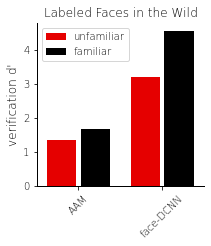

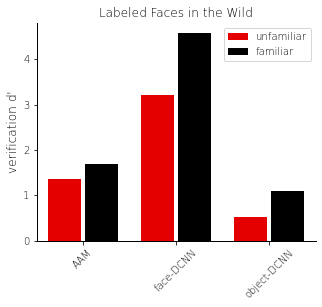

In [4]:
fig, ax = plt.subplots(figsize=(3,3))
sns.barplot("model", "verification d'", hue="familiar", 
            data=all_results[['object' not in model for model in all_results.model]], 
            palette=[sns.xkcd_rgb["red"], 'k'], saturation=1, ax=ax)
change_width(ax, .35)
plt.grid(False)
plt.xticks(rotation=45)
plt.ylabel("verification d'")#, fontsize='x-large')
plt.xlabel("")#, fontsize='x-large')
handles, labels = ax.get_legend_handles_labels() 
plt.title('Labeled Faces in the Wild')
l = plt.legend(handles, ['unfamiliar', 'familiar'], loc='best') # bbox_to_anchor=(1, .8), title='',loc=2, borderaxespad=0.)
plt.savefig(f'{save_dir}/aam_dcnn_comparison.png', dpi=200, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,4))
sns.barplot("model", "verification d'", hue="familiar", 
            data=all_results, 
            palette=[sns.xkcd_rgb["red"], 'k'], saturation=1, ax=ax)
change_width(ax, .35)
plt.grid(False)
plt.xticks(rotation=45)
plt.ylabel("verification d'")#, fontsize='x-large')
plt.xlabel("")#, fontsize='x-large')
plt.title('Labeled Faces in the Wild')
handles, labels = ax.get_legend_handles_labels() 
l = plt.legend(handles, ['unfamiliar', 'familiar'], loc='best') # bbox_to_anchor=(1, .8), title='',loc=2, borderaxespad=0.)
plt.savefig(f'{save_dir}/aam_dcnn_comparison_with_objects.png', dpi=200, bbox_inches='tight')

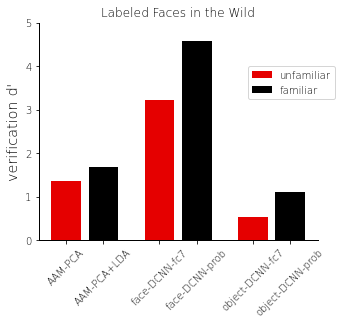

In [5]:
fig, ax = plt.subplots(figsize=(5,4))
# ax.bar([0,1,3,4,6,7], [results['pca'], results['pca_lda'], 
#                         dcnn_results['face']['unfam'], dcnn_results['face']['fam'],
#                         dcnn_results['object']['unfam'], dcnn_results['object']['fam']],
#        color=['r','k', 'r', 'k', 'r', 'k'])
ax.bar([0,2.5,5], [results['pca'], dcnn_results['face']['unfam'], dcnn_results['object']['unfam']],
       color=sns.xkcd_rgb["red"], label='unfamiliar')
ax.bar([1,3.5,6], [results['pca_lda'], dcnn_results['face']['fam'], dcnn_results['object']['fam']],
       color='k', label='familiar')
plt.xticks([0,1,2.5,3.5,5,6], ['AAM-PCA', 'AAM-PCA+LDA', 'face-DCNN-fc7', 'face-DCNN-prob', 'object-DCNN-fc7', 'object-DCNN-prob'], rotation=45)
plt.ylabel("verification d'", fontsize='x-large')
plt.grid(False)
plt.ylim([0,5])
plt.title('Labeled Faces in the Wild')
handles, labels = ax.get_legend_handles_labels() 
l = plt.legend(handles, ['unfamiliar', 'familiar'], bbox_to_anchor=(.75, .8), title='',loc=2, borderaxespad=0.)
plt.savefig(f'{save_dir}/aam_dcnn_comparison_with_objects_alt.png', dpi=400, bbox_inches='tight')

## Simulating ROC analyses for reported values in Kramer et. al 2018, Cognition

In [6]:
rep_results = {'model':[], 'stimulus set':[], "estimated verification d'":[], "familiar":[]}

### CFMT (Figure 9, PCA+LDA space trained on other individuals)

In [7]:
dprime_human_cfmt = norm.ppf(.92) - norm.ppf(1-.88)
dprime_model_cfmt = norm.ppf(.82) - norm.ppf(1-.77)

rep_results['model'].append('PCA+LDA-unfam')
rep_results['stimulus set'].append('CFMT')
rep_results["estimated verification d'"].append(dprime_model_cfmt)
rep_results['familiar'].append(False)

rep_results['model'].append('human')
rep_results['stimulus set'].append('CFMT')
rep_results["estimated verification d'"].append(dprime_human_cfmt)
rep_results['familiar'].append(False)

print(f'model: {dprime_model_cfmt}, human: {dprime_human_cfmt}')

model: 1.6542119370280275, human: 2.5800583523757235


### Other unfamiliar images (Figure 11, PCA space)

In [8]:
dists = {}
dists['matched'] = np.random.normal(loc=127, scale=10, size=10000)
dists['mismatched'] = np.random.normal(loc=134, scale=10, size=10000)
thresh_vals = np.arange(0,1,0.001)

all_dists = np.concatenate((dists['matched'], dists['mismatched']))
all_dists = (all_dists - np.min(all_dists)) / (np.max(all_dists) - np.min(all_dists))
dists['matched'] = all_dists[:len(dists['matched'])]
dists['mismatched'] = all_dists[len(dists['mismatched']):]
tpr, fpr = np.zeros((len(thresh_vals),)), np.zeros((len(thresh_vals),))
for t_i, thresh in enumerate(thresh_vals):
    same = {}
    same['matched'] = dists['matched'] < thresh
    same['mismatched'] = dists['mismatched'] < thresh
    tpr[t_i] = np.mean(same['matched'])
    fpr[t_i] = np.mean(same['mismatched'])
dprime_pca, AUC = dprime_roc_auc(fpr, tpr)
rep_results['model'].append('PCA')
rep_results['stimulus set'].append('Kramer2018')
rep_results["estimated verification d'"].append(dprime_pca)
rep_results['familiar'].append(False)
print(dprime_pca)

0.7049888911407562


### Other familiar images (Figure 11 PCA+LDA space)

In [9]:
dists = {}
dists['matched'] = np.random.normal(loc=103, scale=7, size=10000)
dists['mismatched'] = np.random.normal(loc=126, scale=6, size=10000)
thresh_vals = np.arange(0,1,0.001)

all_dists = np.concatenate((dists['matched'], dists['mismatched']))
all_dists = (all_dists - np.min(all_dists)) / (np.max(all_dists) - np.min(all_dists))
dists['matched'] = all_dists[:len(dists['matched'])]
dists['mismatched'] = all_dists[len(dists['mismatched']):]
tpr, fpr = np.zeros((len(thresh_vals),)), np.zeros((len(thresh_vals),))
for t_i, thresh in enumerate(thresh_vals):
    same = {}
    same['matched'] = dists['matched'] < thresh
    same['mismatched'] = dists['mismatched'] < thresh
    tpr[t_i] = np.mean(same['matched'])
    fpr[t_i] = np.mean(same['mismatched'])
dprime_pca_lda, AUC = dprime_roc_auc(fpr, tpr)
rep_results['model'].append('PCA+LDA')
rep_results['stimulus set'].append('Kramer2018')
rep_results["estimated verification d'"].append(dprime_pca_lda)
rep_results['familiar'].append(True)
print(dprime_pca_lda)

3.505406419410824


In [10]:
rep_results = pd.DataFrame(rep_results)

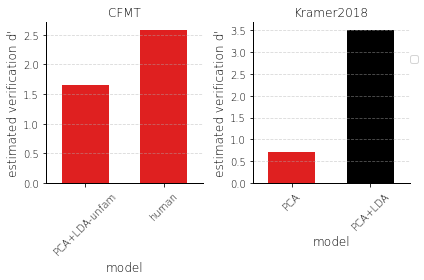

In [11]:
fig, axs = plt.subplots(1,2)
l = sns.barplot("model", "estimated verification d'", 
            data=rep_results[[stim == 'CFMT' for stim in rep_results["stimulus set"]]],
            palette=['r','r'],
            ax=axs[0])
axs[0].set_title('CFMT')
change_width(ax=axs[0], new_value=.6)
l.set_xticklabels(l.get_xticklabels(), rotation=45)
sns.barplot("model", "estimated verification d'",
            data=rep_results[[stim == 'Kramer2018' for stim in rep_results["stimulus set"]]],
            palette=['r','k'],
            ax=axs[1])
axs[1].set_title('Kramer2018')
change_width(ax=axs[1], new_value=.6)
handles, labels = axs[1].get_legend_handles_labels() 
plt.xticks(rotation=45)
axs[1].legend(handles, ['unfamiliar', 'familiar'], bbox_to_anchor=(1, .8), title='',loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

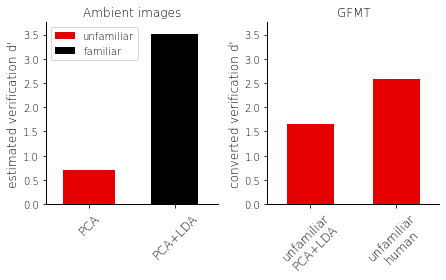

In [12]:
fig, axs = plt.subplots(1,2,figsize=(6.3,4), sharey=False)
axs[0].bar([0], [dprime_pca],
       color=sns.xkcd_rgb["red"], label='unfamiliar', width=.6)
axs[0].bar([1], [dprime_pca_lda],
       color='k', label='familiar', width=.55)
axs[0].set_xticks([0,1])
axs[0].set_xlim([-.5, 1.5])
axs[0].set_ylim([0, 3.75])
axs[0].set_xticklabels(['PCA', 'PCA+LDA'], rotation=45, fontsize='large')
axs[0].set_ylabel("estimated verification d'")
axs[0].legend() #bbox_to_anchor=(1, .8),loc=2, borderaxespad=0.)
axs[0].set_title('Ambient images', fontsize='large')
axs[0].grid(False)
axs[1].bar([0,1], [dprime_model_cfmt, dprime_human_cfmt],
       color=sns.xkcd_rgb["red"], width=0.55)
axs[1].set_xticks([0,1])
axs[1].set_xlim([-.5, 1.5])
axs[1].set_xticklabels(['unfamiliar\nPCA+LDA', 'unfamiliar\nhuman'],rotation=45, fontsize='large')
axs[1].set_title('GFMT', fontsize='large')
axs[1].set_ylabel("converted verification d'")
axs[1].grid(False)
axs[1].set_ylim([0, 3.75])
plt.tight_layout()
fig.savefig(f'{save_dir}/kramer_reanalysis.png')
plt.show()

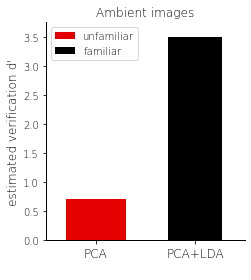

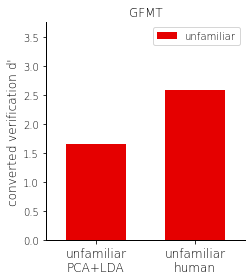

In [13]:
fig, ax = plt.subplots(1,1,figsize=(3.6,4))
ax.bar([0], [dprime_pca],
       color=sns.xkcd_rgb["red"], label='unfamiliar', width=.6)
ax.bar([1], [dprime_pca_lda],
       color='k', label='familiar', width=.55)
ax.set_xticks([0,1])
ax.set_xlim([-.5, 1.5])
ax.set_ylim([0, 3.75])
ax.set_xticklabels(['PCA\n', 'PCA+LDA\n'], rotation=0, fontsize='large')
ax.set_ylabel("estimated verification d'")
ax.legend() #bbox_to_anchor=(1, .8),loc=2, borderaxespad=0.)
ax.set_title('Ambient images', fontsize='large')
ax.grid(False)
plt.tight_layout()
fig.savefig(f'{save_dir}/kramer_reanalysis_a.png')
plt.show()


fig, ax = plt.subplots(1,1,figsize=(3.6,4))
ax.bar([0, 1], [dprime_model_cfmt, dprime_human_cfmt],
       color=sns.xkcd_rgb["red"], label='unfamiliar', width=.6)
ax.set_xticks([0,1])
ax.set_xlim([-.5, 1.5])
ax.set_ylim([0, 3.75])
ax.set_xticklabels(['unfamiliar\nPCA+LDA', 'unfamiliar\nhuman'],rotation=0, fontsize='large')
ax.set_ylabel("converted verification d'")
ax.legend() #bbox_to_anchor=(1, .8),loc=2, borderaxespad=0.)
ax.set_title('GFMT', fontsize='large')
ax.grid(False)
plt.tight_layout()
fig.savefig(f'{save_dir}/kramer_reanalysis_b.png')
plt.show()
